# Basic Controls for Sex
This section of the notebook is dedicated to:
1. Cleaning the data. 
2. Examining the mismatch in years between corruption and BMI data
3. Constructing a basic control for the proportion of men and women in leadership.

In [2]:
# imports & function declarations
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

def regress(dep: pd.Series, indep):
    '''Wrapper for statsmodels regression. Takes in a dependent variable and one or more independent ones'''
    return sm.OLS(
        dep, sm.add_constant(
            indep)
    ).fit()
    

def simple_scatter(x: pd.Series, y: pd.Series, xlabel='', ylabel='', title='', regression_line=True):
    '''Wrapper for matplotlib scatter plot'''
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if regression_line:
        m, b = np.polyfit(x, y, 1)
        ax.plot(x, m*x+b, color='orange')
        
    countries = x.index.values
    plt.show()
    

def annotate_scatter(x:pd.Series, y:pd.Series, annot: dict, x_adjust=0, y_adjust=0, xlabel='', ylabel='', title=''):
    '''Wrapper for matplotlib scatter plot but with annotations'''
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b, color='orange')
    for i, txt in enumerate(x):
        ax.annotate(annot[i], (x[i] + x_adjust, y[i] + y_adjust))
    plt.show()
    

def regress_filtered(col: str):
    '''Regresses BMI on one measure of corruption (col)'''
    index = corruption[col]
    missing_filter = index.notna()
    filtered_bmi = bmis[missing_filter]['median_bmi']
    filtered_index = index[missing_filter]
    return regress(filtered_index, filtered_bmi).summary()


def plot_filtered(col: str, ylabel: str):
    '''Plots BMI against one measure of corruption (col)'''
    index = corruption[col]
    missing_filter = index.notna()
    filtered_bmi = bmis[missing_filter]['median_bmi']
    filtered_index = index[missing_filter]
    simple_scatter(filtered_bmi, filtered_index,
                   'Median estmated ministers\' body-mass index',
                   ylabel)
    

ABBREVIATIONS = {
    'Estonia': 'EST',
    'Lithuania': 'LTU',
    'Latvia': 'LVA',
    'Georgia': 'GEO',
    'Armenia': 'ARM',
    'Russia': 'RUS',
    'Moldova': 'MDA',
    'Belarus': 'BLR',
    'Kyrgyzstan': 'KGZ',
    'Azerbaijan': 'AZE',
    'Tajikistan': 'TJK',
    'Kazakhstan': 'KAZ',
    'Ukraine': 'UKR',
    'Turkmenistan': 'TKM',
    'Uzbekistan': 'UZB'
}

def abbrviate_countries(arr):
    '''Transforms an array of countries into their abbreviated forms'''
    return [ABBREVIATIONS[name] for name in arr]


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
# import minister age and sex data

ministers = pd.read_csv('./ministers.csv', encoding="utf-16")
ministers.head()

,name,sex,age,country,image
0,Karen Karapetyan,M,53.0,Armenia,45bbf60d9a78c802.jpg
1,Vigen Sargsyan,M,42.0,Armenia,7cd0c6d7bb93035.jpg
2,Vache Gabrielyan,M,48.0,Armenia,ac879073ab927981.jpg
3,Suren Karayan,M,44.0,Armenia,a2ba3f513063c0b.jpg
4,Ignati Arakelyan,M,45.0,Armenia,8676f84b0cbeec53.jpg


In [4]:
# clean minister age and sex data and find sex ratios
def filter_sex(sex: str) -> pd.Series:
    '''Filters out ministers by sex'''
    only_sex = ministers[ministers['sex'] == sex]
    return only_sex.groupby('country').count()['sex']
    
only_men = filter_sex('M')
only_women = filter_sex('F')

# calculate sex ratio and add to dataframe
sex_ratio = pd.DataFrame({'men': only_men, 'women': only_women}).fillna(0)
sex_ratio['women'] = sex_ratio['women'].astype(int)
sex_ratio['total'] = sex_ratio['men'] + sex_ratio['women']

sex_ratio['ratio'] = sex_ratio['men'] / sex_ratio['total']
sex_ratio.columns

Index(['men', 'women', 'total', 'ratio'], dtype='object')

In [5]:
# import and clean WHO BMI data
bmi = pd.read_csv('./WHO-BMI.csv', encoding="utf-8", index_col=0)

def clean_bmi(row: pd.Series) -> pd.Series:
    '''Cleans up and numberfies the numerical strings in a row. e.g. "26.5 [26.0-27.1]" to 26.5'''
    replaced = row.str.replace(r' \[\d{1,2}.?\d{1,2}-\d{1,2}.?\d{1,2}]', '', regex=True)
    return replaced.astype(float)


for r in bmi.columns:
    bmi[r] = clean_bmi(bmi[r])
    
# bmi data is easier to deal with reversed
bmi = bmi.iloc[:, ::-1]

# gets only first columns i.e. 2017 data
bmi_2017 = bmi[['2016Both sexes', '2016Male', '2016Female']]
bmi_2017.head(15)


,2016Both sexes,2016Male,2016Female
Country,,,
Armenia,26.5,25.6,27.5
Azerbaijan,27.0,26.1,27.9
Belarus,27.2,26.7,27.7
Estonia,27.0,27.2,26.8
Georgia,28.1,27.7,28.4
Kazakhstan,26.4,26.2,26.6
Kyrgyzstan,26.2,25.6,26.8
Latvia,27.4,27.3,27.5
Lithuania,27.0,27.3,26.8


## Graphing BMIs over time
There was some concern in the review process that using slightly out of date BMI data would be a problem for my results. The corruption data is all from 2017, while the latest WHO BMI data is from 2016. However, these charts illustrate two things.
1. BMI is on a steady, and within the past few years, comparable upswing
2. BMI increases very slowly over time, so 2016's values are likely to be very similar to 2017's.

Text(0, 0.5, 'Mean Female BMI (WHO)')

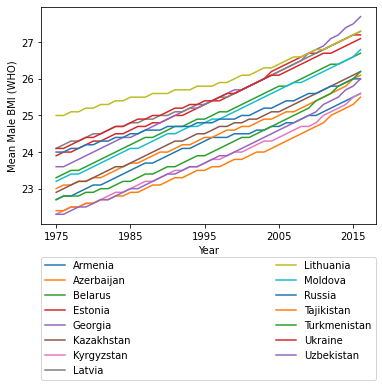

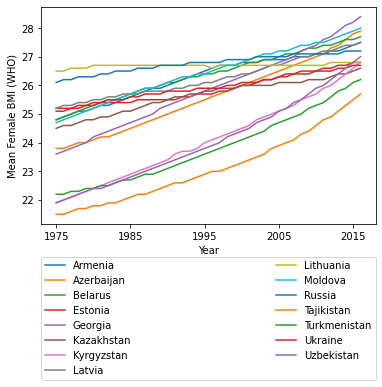

In [6]:
# graph male and female BMIs over time
male_cols = [el for el in bmi.columns if "Male" in el]
female_cols = [el for el in bmi.columns if "Female" in el]
both_cols = [el for el in bmi.columns if "Both" in el]

def strip_to_year(col):
    return col[:4]

male_bmi_time = bmi.loc[:,male_cols].rename(strip_to_year, axis=1).T
female_bmi_time = bmi.loc[:, female_cols].rename(
    strip_to_year, axis=1).T
m_plot = male_bmi_time.plot(legend=False)
m_plot.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2,
                 ncol=2, mode="expand", borderaxespad=0)
m_plot.set_xlabel('Year')
m_plot.set_ylabel('Mean Male BMI (WHO)')

f_plot = female_bmi_time.plot(legend=False)
f_plot.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2,
              ncol=2, mode="expand", borderaxespad=0)
f_plot.set_xlabel('Year')
f_plot.set_ylabel('Mean Female BMI (WHO)')


In [7]:
# merge bmi data and minister data
bmi_with_ministers = pd.merge(
    sex_ratio, bmi_2017, left_index=True, right_on='Country')
bmi_with_ministers = bmi_with_ministers.rename({'men': 'men_in_gov', 'women': 'women_in_gov', 'total': 'minister_count', 'ratio': 'minister_sex_ratio', 'Country': 'country', '2016Both sexes': 'both_sexes_bmi', '2016Male': 'male_bmi', '2016Female': 'female_bmi'}, axis = 1)
bmi_with_ministers.head(15)

,men_in_gov,women_in_gov,minister_count,minister_sex_ratio,both_sexes_bmi,male_bmi,female_bmi
Country,,,,,,,
Armenia,18,1,19,0.947368,26.5,25.6,27.5
Azerbaijan,26,0,26,1.000000,27.0,26.1,27.9
Belarus,28,2,30,0.933333,27.2,26.7,27.7
Estonia,11,4,15,0.733333,27.0,27.2,26.8
Georgia,19,2,21,0.904762,28.1,27.7,28.4
Kazakhstan,18,1,19,0.947368,26.4,26.2,26.6
Kyrgyzstan,14,3,17,0.823529,26.2,25.6,26.8
Latvia,11,3,14,0.785714,27.4,27.3,27.5
Lithuania,12,3,15,0.800000,27.0,27.3,26.8


In [8]:
# puts median minister data (taken from Blavatskyy's paper) into dataframe with minister and BMI data
median_ministers = {
    'Estonia': 28.7,
    'Lithuania': 30.3,
    'Latvia': 30.7,
    'Georgia': 30.9,
    'Armenia': 32.1,
    'Russia': 32.5,
    'Moldova': 32.7,
    'Belarus': 32.9,
    'Kyrgyzstan': 33.3,
    'Azerbaijan': 33.3,
    'Tajikistan': 33.6,
    'Kazakhstan': 33.8,
    'Ukraine': 34.4,
    'Turkmenistan': 34.7,
    'Uzbekistan': 35.5
}

bmi_with_ministers['median_minister_bmi'] = bmi_with_ministers.index.map(median_ministers)
bmi_with_ministers.head(15)


,men_in_gov,women_in_gov,minister_count,minister_sex_ratio,both_sexes_bmi,male_bmi,female_bmi,median_minister_bmi
Country,,,,,,,,
Armenia,18,1,19,0.947368,26.5,25.6,27.5,32.1
Azerbaijan,26,0,26,1.000000,27.0,26.1,27.9,33.3
Belarus,28,2,30,0.933333,27.2,26.7,27.7,32.9
Estonia,11,4,15,0.733333,27.0,27.2,26.8,28.7
Georgia,19,2,21,0.904762,28.1,27.7,28.4,30.9
Kazakhstan,18,1,19,0.947368,26.4,26.2,26.6,33.8
Kyrgyzstan,14,3,17,0.823529,26.2,25.6,26.8,33.3
Latvia,11,3,14,0.785714,27.4,27.3,27.5,30.7
Lithuania,12,3,15,0.800000,27.0,27.3,26.8,30.3


In [9]:
# creates sex-adjusted BMI by weighing the proportion of men and women in leadership
men_ratio = bmi_with_ministers['minister_sex_ratio']
women_ratio = 1 - men_ratio
men_bmi = bmi_with_ministers['male_bmi']
women_bmi = bmi_with_ministers['female_bmi']
total_num = bmi_with_ministers['minister_count']
adjusted_bmi = ((men_ratio * men_bmi) + (women_ratio * women_bmi))
bmi_with_ministers['adjusted_bmi'] = adjusted_bmi

bmi_with_ministers.head(15)

,men_in_gov,women_in_gov,minister_count,minister_sex_ratio,both_sexes_bmi,male_bmi,female_bmi,median_minister_bmi,adjusted_bmi
Country,,,,,,,,,
Armenia,18,1,19,0.947368,26.5,25.6,27.5,32.1,25.700000
Azerbaijan,26,0,26,1.000000,27.0,26.1,27.9,33.3,26.100000
Belarus,28,2,30,0.933333,27.2,26.7,27.7,32.9,26.766667
Estonia,11,4,15,0.733333,27.0,27.2,26.8,28.7,27.093333
Georgia,19,2,21,0.904762,28.1,27.7,28.4,30.9,27.766667
Kazakhstan,18,1,19,0.947368,26.4,26.2,26.6,33.8,26.221053
Kyrgyzstan,14,3,17,0.823529,26.2,25.6,26.8,33.3,25.811765
Latvia,11,3,14,0.785714,27.4,27.3,27.5,30.7,27.342857
Lithuania,12,3,15,0.800000,27.0,27.3,26.8,30.3,27.200000


In [10]:
# regresses adjusted BMI on minister BMI
adjusted_minister_country_relation = regress(adjusted_bmi, bmi_with_ministers['median_minister_bmi'])

adjusted_minister_country_relation.summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     6.248
Date:                Thu, 14 Jul 2022   Prob (F-statistic):             0.0266
Time:                        19:08:36   Log-Likelihood:                -12.058
No. Observations:                  15   AIC:                             28.12
Df Residuals:                      13   BIC:                             29.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  33.4505      2.773     12.065      0.000      27.461      39.440
median_minister_bmi    -0.2121      0.085     -2.500      0.027      -0.395      -0.029
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.503
Skew:                          -0.053   Prob(JB):                        0.778
Kurtosis:                       2.109   Cond. No.                         605.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# regresses unadjusted country BMI on minister BMI
unadjusted_minister_country_relation = regress(
    bmi_with_ministers['both_sexes_bmi'],
    bmi_with_ministers['median_minister_bmi']
    )

unadjusted_minister_country_relation.summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         both_sexes_bmi   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     4.885
Date:                Thu, 14 Jul 2022   Prob (F-statistic):             0.0456
Time:                        19:08:36   Log-Likelihood:                -10.960
No. Observations:                  15   AIC:                             25.92
Df Residuals:                      13   BIC:                             27.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  32.4937      2.577     12.610      0.000      26.927      38.061
median_minister_bmi    -0.1743      0.079     -2.210      0.046      -0.345      -0.004
==============================================================================
Omnibus:                        0.041   Durbin-Watson:                   2.377
Prob(Omnibus):                  0.980   Jarque-Bera (JB):                0.099
Skew:                          -0.023   Prob(JB):                        0.951
Kurtosis:                       2.604   Cond. No.                         605.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

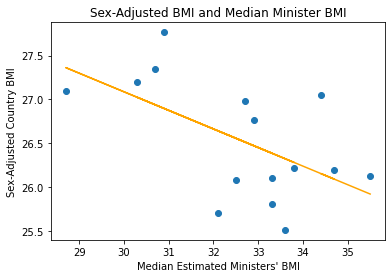

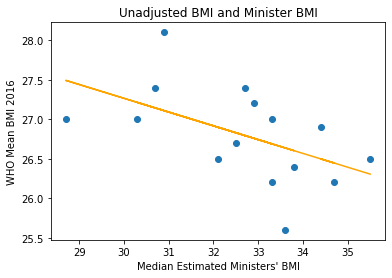

In [12]:
# plots adjusted and unadjusted BMI on minister BMI

simple_scatter(
    bmi_with_ministers['median_minister_bmi'], 
    adjusted_bmi, 
    'Median Estimated Ministers\' BMI', 
    'Sex-Adjusted Country BMI', 
    'Sex-Adjusted BMI and Median Minister BMI'
    )

simple_scatter(
    bmi_with_ministers['median_minister_bmi'],
    bmi_with_ministers['both_sexes_bmi'],
    'Median Estimated Ministers\' BMI',
    'WHO Mean BMI 2016',
    'Unadjusted BMI and Minister BMI'
    )


In [13]:
# finds difference between mean male and female BMIs in each country
bmi_diff = bmi_with_ministers['male_bmi'] - bmi_with_ministers['female_bmi']
print(bmi_diff.mean())
print(bmi_diff)

-0.6333333333333329
Country
Armenia        -1.9
Azerbaijan     -1.8
Belarus        -1.0
Estonia         0.4
Georgia        -0.7
Kazakhstan     -0.4
Kyrgyzstan     -1.2
Latvia         -0.2
Lithuania       0.5
Moldova        -1.2
Russia         -1.2
Tajikistan     -0.2
Turkmenistan    0.0
Ukraine         0.4
Uzbekistan     -1.0
dtype: float64


# Basic Controls for Age
This section is dedicated to controlling the data for the age of the ministers

In [14]:
# finds mean and median age of ministers in each country
# too many Tajik ministers missing ages to use country's data
ministers_age = ministers[ministers['country'] != 'Tajikistan']
ministers_age = ministers_age[ministers_age['age'].notna()]
grouped_ministers_age = ministers_age.groupby('country')
mean_age = grouped_ministers_age['age'].mean()
median_age = grouped_ministers_age['age'].median()

print(mean_age, median_age)

country
Armenia         49.421053
Azerbaijan      61.160000
Belarus         54.115385
Estonia         46.666667
Georgia         43.000000
Kazakhstan      49.315789
Kyrgyzstan      54.000000
Latvia          50.071429
Lithuania       45.615385
Moldova         45.833333
Russia          51.870968
Turkmenistan    52.444444
Ukraine         47.652174
Uzbekistan      54.705882
Name: age, dtype: float64 country
Armenia         49.0
Azerbaijan      61.0
Belarus         54.0
Estonia         45.0
Georgia         42.5
Kazakhstan      52.0
Kyrgyzstan      52.0
Latvia          49.5
Lithuania       47.0
Moldova         44.0
Russia          52.0
Turkmenistan    51.0
Ukraine         49.0
Uzbekistan      55.0
Name: age, dtype: float64


In [15]:
# creates dataframe of age data

# from UN World Population Prospects 2015
ages_2015 = {
    'Azerbaijan': 33.8,
    'Armenia': 30.3,
    'Georgia': 37.7,
    'Kazakhstan': 29.4,
    'Kyrgyzstan': 25.1,
    # 'Tajikistan': 22.0,
    'Turkmenistan': 25.6,
    'Uzbekistan': 26.2,
    'Belarus': 39.5,
    'Moldova': 35.6,
    'Russia': 38.6,
    'Ukraine': 40.0,
    'Estonia': 41.6,
    'Latvia': 42.6,
    'Lithuania': 42.7,
}

country_ages = pd.Series(ages_2015)
age_data = pd.concat([country_ages, mean_age, median_age], axis=1)
age_data.set_axis(['mean_country_age', 'mean_minister_age', 'median_minister_age'], axis=1, inplace=True)
age_data

,mean_country_age,mean_minister_age,median_minister_age
Azerbaijan,33.8,61.160000,61.0
Armenia,30.3,49.421053,49.0
Georgia,37.7,43.000000,42.5
Kazakhstan,29.4,49.315789,52.0
Kyrgyzstan,25.1,54.000000,52.0
Turkmenistan,25.6,52.444444,51.0
Uzbekistan,26.2,54.705882,55.0
Belarus,39.5,54.115385,54.0
Moldova,35.6,45.833333,44.0
Russia,38.6,51.870968,52.0


Country
Armenia         32.1
Azerbaijan      33.3
Belarus         32.9
Estonia         28.7
Georgia         30.9
Kazakhstan      33.8
Kyrgyzstan      33.3
Latvia          30.7
Lithuania       30.3
Moldova         32.7
Russia          32.5
Turkmenistan    34.7
Ukraine         34.4
Uzbekistan      35.5
Name: median_minister_bmi, dtype: float64
Azerbaijan      61.160000
Armenia         49.421053
Georgia         43.000000
Kazakhstan      49.315789
Kyrgyzstan      54.000000
Turkmenistan    52.444444
Uzbekistan      54.705882
Belarus         54.115385
Moldova         45.833333
Russia          51.870968
Ukraine         47.652174
Estonia         46.666667
Latvia          50.071429
Lithuania       45.615385
Name: mean_minister_age, dtype: float64


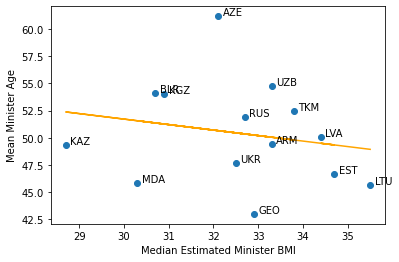

In [16]:
# compare politicians BMI and ages
med_minister_bmi = bmi_with_ministers.drop('Tajikistan')
print(med_minister_bmi.median_minister_bmi)
print(age_data.mean_minister_age)

annotate_scatter(
    med_minister_bmi.median_minister_bmi,
    age_data.mean_minister_age,
    abbrviate_countries(age_data['mean_minister_age'].index.values),
    0.1, 0.1, 'Median Estimated Minister BMI', 'Mean Minister Age'
    )


In [17]:
regress(age_data['mean_minister_age'].sort_index(), med_minister_bmi.median_minister_bmi.sort_index()).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mean_minister_age   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     4.543
Date:                Thu, 14 Jul 2022   Prob (F-statistic):             0.0544
Time:                        19:08:38   Log-Likelihood:                -38.825
No. Observations:                  14   AIC:                             81.65
Df Residuals:                      12   BIC:                             82.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.5213     20.158      0.373      0.716     -36.400      51.443
median_minister_bmi     1.3176      0.618      2.131      0.054      -0.029       2.665
==============================================================================
Omnibus:                        3.521   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                1.379
Skew:                           0.709   Prob(JB):                        0.502
Kurtosis:                       3.594   Cond. No.                         588.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# regresses mean minister age on mean country age
mean_age_relationship = regress(age_data['mean_minister_age'], age_data['mean_country_age'])
mean_age_relationship.summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mean_minister_age   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     2.822
Date:                Thu, 14 Jul 2022   Prob (F-statistic):              0.119
Time:                        19:08:38   Log-Likelihood:                -39.594
No. Observations:                  14   AIC:                             83.19
Df Residuals:                      12   BIC:                             84.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               61.5238      6.714      9.163      0.000      46.894      76.153
mean_country_age    -0.3181      0.189     -1.680      0.119      -0.731       0.094
==============================================================================
Omnibus:                        4.944   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                2.250
Skew:                           0.906   Prob(JB):                        0.325
Kurtosis:                       3.755   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

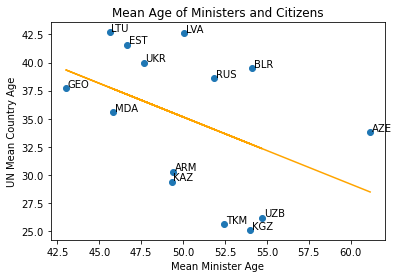

In [19]:
# makes scatter plot of minister age and mean country age
annotate_scatter(age_data['mean_minister_age'], 
                 age_data['mean_country_age'],
                 abbrviate_countries(age_data['mean_country_age'].index.values),
                 0.1,0.1,
                 'Mean Minister Age', 'UN Mean Country Age', 'Mean Age of Ministers and Citizens')


In [20]:
corruption = pd.read_csv('corruption.csv').set_index('country')
corruption.drop('Tajikistan', inplace=True)
corruption

,control_of_corruption,corruption perception index,basel anti money laundering,IDEA absence of corruption,Index of public integrity
country,,,,,
Armenia,-0.56,35,4.44,0.323753,NaN
Azerbaijan,-0.89,31,4.77,0.121495,6.227309
Belarus,-0.26,44,NaN,0.482308,NaN
Estonia,1.25,71,2.73,0.785597,8.877991
Georgia,0.74,56,5.28,0.651742,7.179274
Kazakhstan,-0.82,31,6.35,0.305049,5.627002
Kyrgyzstan,-1.06,29,6.24,0.225880,5.525407
Latvia,0.56,58,3.64,0.659737,7.912312
Lithuania,0.54,59,3.67,0.669400,7.688306


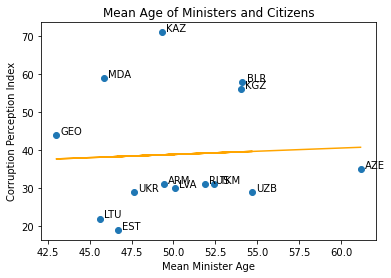

In [21]:
annotate_scatter(age_data['mean_minister_age'],
                 corruption['corruption perception index'],
                 abbrviate_countries(age_data['mean_country_age'].index.values),
                 0.25,0.25,
                 'Mean Minister Age', 'Corruption Perception Index', 'Mean Age of Ministers and Citizens')


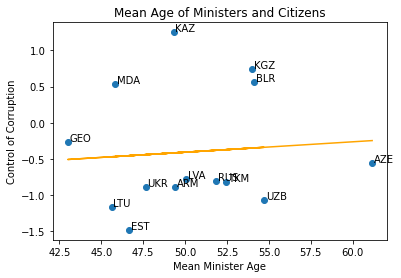

In [22]:
annotate_scatter(age_data['mean_minister_age'],
                 corruption['control_of_corruption'],
                 abbrviate_countries(age_data['mean_country_age'].index.values),
                 0.1,0.01,
                 'Mean Minister Age', 'Control of Corruption', 'Mean Age of Ministers and Citizens')


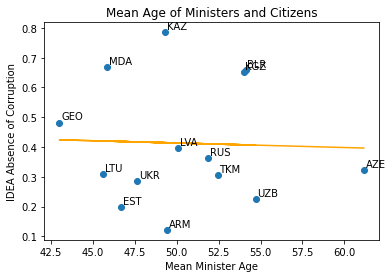

In [23]:
annotate_scatter(age_data['mean_minister_age'],
                 corruption['IDEA absence of corruption'],
                 abbrviate_countries(
                     age_data['mean_country_age'].index.values),
                 0.1, 0.01,
                 'Mean Minister Age', 'IDEA Absence of Corruption', 'Mean Age of Ministers and Citizens')


In [24]:
regress(corruption['corruption perception index'].sort_index(),
        age_data['mean_minister_age'].sort_index()).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.269
Model:                                     OLS   Adj. R-squared:                  0.208
Method:                          Least Squares   F-statistic:                     4.424
Date:                         Thu, 14 Jul 2022   Prob (F-statistic):             0.0572
Time:                                 19:08:39   Log-Likelihood:                -55.858
No. Observations:                           14   AIC:                             115.7
Df Residuals:                               12   BIC:                             117.0
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               126.9416     42.016      3.021      0.011      35.397     218.486
mean_minister_age    -1.7456      0.830     -2.103      0.057      -3.554       0.063
==============================================================================
Omnibus:                        1.720   Durbin-Watson:                   1.102
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.144
Skew:                           0.443   Prob(JB):                        0.565
Kurtosis:                       1.917   Cond. No.                         564.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
regress(
    corruption['control_of_corruption'].sort_index(), 
    age_data['mean_minister_age'].sort_index()
    ).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.328
Model:                               OLS   Adj. R-squared:                  0.272
Method:                    Least Squares   F-statistic:                     5.853
Date:                   Thu, 14 Jul 2022   Prob (F-statistic):             0.0324
Time:                           19:08:39   Log-Likelihood:                -14.002
No. Observations:                     14   AIC:                             32.00
Df Residuals:                         12   BIC:                             33.28
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.6917      2.113      2.220      0.046       0.087       9.297
mean_minister_age    -0.1010      0.042     -2.419      0.032      -0.192      -0.010
==============================================================================
Omnibus:                        1.451   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                0.994
Skew:                           0.373   Prob(JB):                        0.608
Kurtosis:                       1.928   Cond. No.                         564.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
regress(
    corruption['IDEA absence of corruption'].sort_index(),
    age_data['mean_minister_age'].sort_index()
).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.472
Model:                                    OLS   Adj. R-squared:                  0.428
Method:                         Least Squares   F-statistic:                     10.74
Date:                        Thu, 14 Jul 2022   Prob (F-statistic):            0.00662
Time:                                19:08:39   Log-Likelihood:                 7.3694
No. Observations:                          14   AIC:                            -10.74
Df Residuals:                              12   BIC:                            -9.461
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9117      0.459      4.163      0.001       0.911       2.912
mean_minister_age    -0.0297      0.009     -3.277      0.007      -0.049      -0.010
==============================================================================
Omnibus:                        1.821   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.402   Jarque-Bera (JB):                1.279
Skew:                           0.532   Prob(JB):                        0.528
Kurtosis:                       1.970   Cond. No.                         564.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Reproducibility
This section is dedicated to reproducing Blavatskyy's results with his method

In [27]:
# get BMI of each minister -- commented out because it takes forever to run
# from bmipredictor import BMIPredictor
# bmi_predictor = BMIPredictor()
# # this is a test prediction
# # bmi_predictor.predict(
# #     'http://npg.si.edu/sites/default/files/blog_obama_martin_schoeller.jpg')

# estimated_bmi = ministers['image'].apply(lambda img : bmi_predictor.predict('./2017-images/' + img))
# estimated_bmi.head(20)

# # save BMI to CSV so we don't need to do ML over and over
# ministers['estimated_bmi'] = estimated_bmi
# ministers.to_csv('ministers2.csv')


In [28]:
estimated_ministers = pd.read_csv('ministers2.csv')
# remove buggy extra index col
estimated_ministers = estimated_ministers[['name', 'age', 'sex', 'country', 'image', 'estimated_bmi']]
median_bmi = estimated_ministers[['country', 'estimated_bmi']].groupby('country').median().rename({'estimated_bmi': 'median_bmi'}, axis=1)
mean_bmis = estimated_ministers[['country', 'estimated_bmi']].groupby('country').mean().rename({'estimated_bmi': 'mean_bmi'}, axis=1)

bmis = pd.concat([median_bmi, mean_bmis], axis = 1)
bmis['reported_median_bmis'] = pd.Series(median_ministers)

bmis[['median_bmi', 'mean_bmi', 'reported_median_bmis']].sort_values('reported_median_bmis').round(1)

,median_bmi,mean_bmi,reported_median_bmis
country,,,
Estonia,28.8,30.4,28.7
Lithuania,30.3,31.8,30.3
Latvia,30.7,31.2,30.7
Georgia,31.0,32.2,30.9
Armenia,32.2,31.7,32.1
Russia,32.5,32.5,32.5
Moldova,32.8,33.2,32.7
Belarus,32.8,33.5,32.9
Azerbaijan,33.3,32.9,33.3


In [29]:
corruption = pd.read_csv('corruption.csv').set_index('country')
corruption

,control_of_corruption,corruption perception index,basel anti money laundering,IDEA absence of corruption,Index of public integrity
country,,,,,
Armenia,-0.56,35,4.44,0.323753,NaN
Azerbaijan,-0.89,31,4.77,0.121495,6.227309
Belarus,-0.26,44,NaN,0.482308,NaN
Estonia,1.25,71,2.73,0.785597,8.877991
Georgia,0.74,56,5.28,0.651742,7.179274
Kazakhstan,-0.82,31,6.35,0.305049,5.627002
Kyrgyzstan,-1.06,29,6.24,0.225880,5.525407
Latvia,0.56,58,3.64,0.659737,7.912312
Lithuania,0.54,59,3.67,0.669400,7.688306


In [30]:
regress_filtered('control_of_corruption')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.835
Model:                               OLS   Adj. R-squared:                  0.822
Method:                    Least Squares   F-statistic:                     65.63
Date:                   Thu, 14 Jul 2022   Prob (F-statistic):           1.95e-06
Time:                           19:08:40   Log-Likelihood:                -4.6074
No. Observations:                     15   AIC:                             13.21
Df Residuals:                         13   BIC:                             14.63
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3953      1.713      7.820      0.000       9.695      17.096
median_bmi    -0.4244      0.052     -8.101      0.000      -0.538      -0.311
==============================================================================
Omnibus:                        1.719   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                0.906
Skew:                           0.114   Prob(JB):                        0.636
Kurtosis:                       1.818   Cond. No.                         614.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

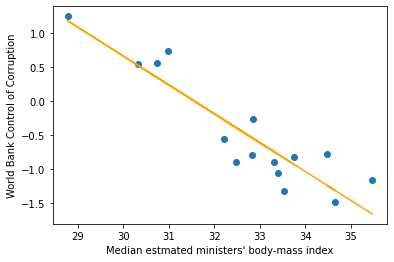

In [31]:
plot_filtered('control_of_corruption', 'World Bank Control of Corruption')

In [32]:
regress_filtered('corruption perception index')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.860
Model:                                     OLS   Adj. R-squared:                  0.850
Method:                          Least Squares   F-statistic:                     80.03
Date:                         Thu, 14 Jul 2022   Prob (F-statistic):           6.45e-07
Time:                                 19:08:40   Log-Likelihood:                -47.581
No. Observations:                           15   AIC:                             99.16
Df Residuals:                               13   BIC:                             100.6
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        306.2530     30.059     10.189      0.000     241.315     371.191
median_bmi    -8.2239      0.919     -8.946      0.000     -10.210      -6.238
==============================================================================
Omnibus:                        1.388   Durbin-Watson:                   0.934
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                0.934
Skew:                          -0.295   Prob(JB):                        0.627
Kurtosis:                       1.929   Cond. No.                         614.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

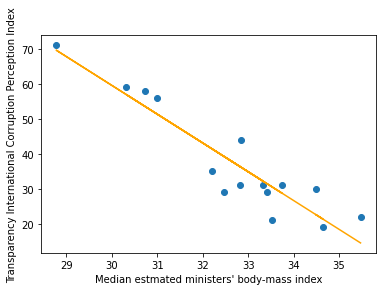

In [33]:
plot_filtered('corruption perception index', ylabel='Transparency International Corruption Perception Index')

In [34]:
regress_filtered('basel anti money laundering')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     basel anti money laundering   R-squared:                       0.612
Model:                                     OLS   Adj. R-squared:                  0.577
Method:                          Least Squares   F-statistic:                     17.38
Date:                         Thu, 14 Jul 2022   Prob (F-statistic):            0.00157
Time:                                 19:08:40   Log-Likelihood:                -16.746
No. Observations:                           13   AIC:                             37.49
Df Residuals:                               11   BIC:                             38.62
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.8399      4.839     -3.066      0.011     -25.492      -4.188
median_bmi     0.6202      0.149      4.169      0.002       0.293       0.948
==============================================================================
Omnibus:                        7.489   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                3.661
Skew:                           1.133   Prob(JB):                        0.160
Kurtosis:                       4.276   Cond. No.                         596.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

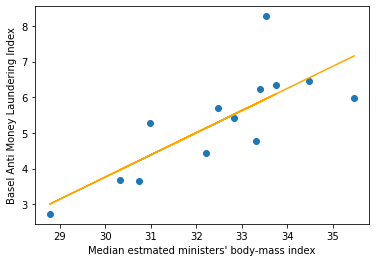

In [35]:
plot_filtered('basel anti money laundering', ylabel='Basel Anti Money Laundering Index')

In [36]:
regress_filtered('IDEA absence of corruption')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.653
Model:                                    OLS   Adj. R-squared:                  0.627
Method:                         Least Squares   F-statistic:                     24.51
Date:                        Thu, 14 Jul 2022   Prob (F-statistic):           0.000265
Time:                                19:08:40   Log-Likelihood:                 10.497
No. Observations:                          15   AIC:                            -16.99
Df Residuals:                              13   BIC:                            -15.58
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4867      0.626      5.571      0.000       2.135       4.839
median_bmi    -0.0948      0.019     -4.950      0.000      -0.136      -0.053
==============================================================================
Omnibus:                        0.949   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.622   Jarque-Bera (JB):                0.749
Skew:                          -0.217   Prob(JB):                        0.687
Kurtosis:                       1.995   Cond. No.                         614.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

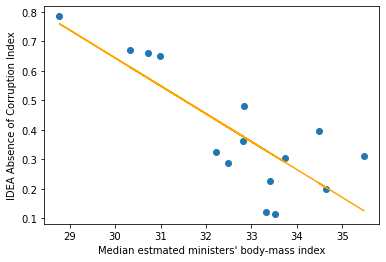

In [37]:
plot_filtered('IDEA absence of corruption', 'IDEA Absence of Corruption Index')


In [38]:
regress_filtered('Index of public integrity')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Index of public integrity   R-squared:                       0.850
Model:                                   OLS   Adj. R-squared:                  0.833
Method:                        Least Squares   F-statistic:                     50.98
Date:                       Thu, 14 Jul 2022   Prob (F-statistic):           5.43e-05
Time:                               19:08:41   Log-Likelihood:                -6.7101
No. Observations:                         11   AIC:                             17.42
Df Residuals:                              9   BIC:                             18.22
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.7536      2.835      9.437      0.000      20.341      33.166
median_bmi    -0.6270      0.088     -7.140      0.000      -0.826      -0.428
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.127
Skew:                          -0.052   Prob(JB):                        0.939
Kurtosis:                       2.484   Cond. No.                         617.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

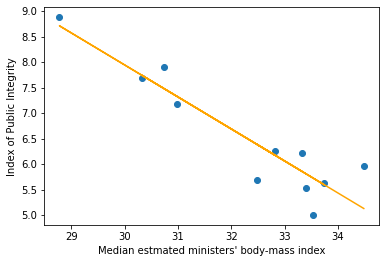

In [39]:
plot_filtered('Index of public integrity', 'Index of Public Integrity')

# Test for difference between women in gov and not

In [40]:
# bmi_with_ministers
mean_f_minister_bmi = estimated_ministers[ministers.sex == 'F'].groupby('country').mean().estimated_bmi
mean_f_bmi = bmi['2016Female']
mean_f_bmi.drop('Azerbaijan', inplace=True) # Azerbaijan has no female ministers

mean_f_bmi.index = mean_f_minister_bmi.index
f_bmi_comparison = pd.concat([mean_f_minister_bmi, bmi['2016Female']], axis=1, sort=True)
f_bmi_comparison


,estimated_bmi,2016Female
Armenia,27.363757,27.5
Azerbaijan,NaN,27.9
Belarus,34.877650,27.7
Estonia,27.803549,26.8
Georgia,28.248496,28.4
Kazakhstan,30.817848,26.6
Kyrgyzstan,31.498928,26.8
Latvia,28.240949,27.5
Lithuania,27.678877,26.8
Moldova,32.197474,28.0


# Building Standardized BMI

In [41]:
# # get data from (non-comitted) .sav files from the Health in Times of Transition 2010 survey
# # takes a while to run
# hitt1 = pd.read_spss('./Data/EAB_2_26 10 14.sav')

# hitt1_country_abbr = hitt1['COUNTRIES']
# hitt1_sex = hitt1['V010']
# hitt1_age = hitt1['V011']
# hitt1_height = hitt1['V024']
# hitt1_weight = hitt1['V025']

# hitt1_trimmed = pd.concat([
#     hitt1_country_abbr,
#     hitt1_sex,
#     hitt1_age,
#     pd.to_numeric(hitt1_height),
#     pd.to_numeric(hitt1_weight),
# ], axis=1)

# hitt1_trimmed.rename(columns={
#     'COUNTRIES': 'country',
#     'V010': 'sex',
#     'V011': 'age',
#     'V024': 'height',
#     'V025': 'weight'
# }, inplace=True)

# # formula from https://www.cdc.gov/nccdphp/dnpao/growthcharts/training/bmiage/page5_1.html
# hitt1_trimmed['bmi'] = (
#     (hitt1_trimmed['weight'] / (hitt1_trimmed['height']**2)) * 10000).round(1)
# hitt1_trimmed.drop(['height', 'weight'], axis=1, inplace=True)

# abbrv_transform = {
#     'MD': 'Moldova',
#     'BY': 'Belarus',
#     'RU': 'Russia',
#     'KG': 'Kyrgyzstan',
#     'KZ': 'Kazakhstan',
#     'UA': 'Ukraine',
#     'AM': 'Armenia',
#     'GE': 'Georgia',
#     'AZ': 'Azerbaijan'
# }

# hitt1_trimmed['country'] = hitt1_trimmed.replace({'country': abbrv_transform})
# hitt1_trimmed.to_csv('./Data/hitt_trimmed.csv')


In [346]:
# uses saved cleaned data from above
hitt = pd.read_csv('./Data/hitt_trimmed.csv')
# remove missing data
print(hitt.shape)
hitt = hitt.dropna()
print(hitt.shape)
hitt.head()

(18000, 5)
(16943, 5)


,Unnamed: 0,country,sex,age,bmi
0,0,Moldova,Female,51.0,33.5
1,1,Moldova,Female,82.0,20.0
2,2,Moldova,Male,50.0,24.7
3,3,Moldova,Female,42.0,22.8
4,4,Moldova,Female,37.0,23.9


## HITT Cleaning

In [347]:
# removal of outliers: BMI > 50 
hitt = hitt[hitt['bmi'] < 40]

hitt['age_dm'] = hitt.age - hitt.age.mean()

hitt_men = hitt[hitt['sex'] == 'Male']
hitt_women = hitt[hitt['sex'] == 'Female']

hitt_men.shape[0] + hitt_women.shape[0] == hitt.shape[0]

True

In [288]:
hitt.describe()

,Unnamed: 0,age,bmi,age_demeaned
count,11562.000000,11562.000000,11562.00000,1.156200e+04
mean,8841.410483,50.834458,26.25730,-3.452112e-14
std,5147.231972,13.546344,4.33196,1.354634e+01
min,0.000000,31.000000,12.30000,-1.983446e+01
25%,4394.250000,40.000000,23.10000,-1.083446e+01
50%,8827.500000,49.000000,25.70000,-1.834458e+00
75%,13257.500000,60.000000,29.00000,9.165542e+00
max,17999.000000,95.000000,39.90000,4.416554e+01


In [191]:
# prepare minister data for regression estimation
estimated_ministers_wot = estimated_ministers[estimated_ministers['country'] != 'Tajikistan']
print(estimated_ministers_wot.shape)
estimated_ministers_trimmed = estimated_ministers_wot[~np.isnan(estimated_ministers_wot.age)]
estimated_ministers_trimmed = estimated_ministers_trimmed[~np.isnan(estimated_ministers_trimmed.age)]

estimated_ministers_trimmed['sex'] = estimated_ministers_trimmed['sex'].map({'M': 'Male', 'F': 'Female'})


(281, 6)


In [192]:
estimated_ministers_trimmed.describe()

,age,estimated_bmi
count,244.000000,244.000000
mean,50.991803,32.975715
std,8.748423,4.039872
min,31.000000,23.148934
25%,44.750000,30.227439
50%,51.000000,33.009813
75%,57.000000,35.985783
max,82.000000,42.414076


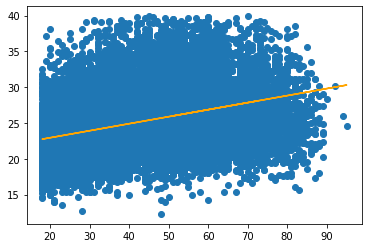

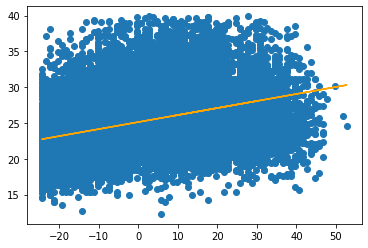

In [349]:
simple_scatter(hitt.age, hitt.bmi)
simple_scatter(hitt.age_dm, hitt.bmi)
# simple_scatter(hitt_men.age, hitt_men.bmi)
# simple_scatter(hitt_women.age, hitt_women.bmi)

array([[<AxesSubplot:title={'center':'bmi'}>]], dtype=object)

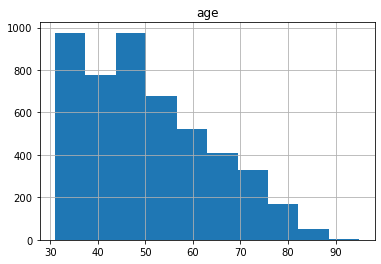

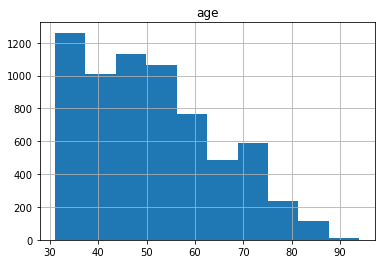

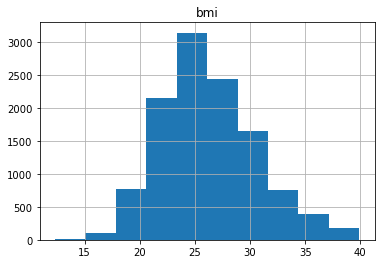

In [292]:
hitt_men.hist(column='age')
hitt_women.hist(column='age')

hitt.hist(column='bmi')

## Model Building

In [354]:
age_sex_regress_t = sm.WLS.from_formula(formula='bmi ~ age + C(sex)', data=hitt).fit()
age_sex_regress_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.144
Model:                            WLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     1410.
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        21:45:46   Log-Likelihood:                -47483.
No. Observations:               16793   AIC:                         9.497e+04
Df Residuals:                   16790   BIC:                         9.500e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         20.8271      0.091    229.338      0.000      20.649      21.005
C(sex)[T.Male]     0.2860      0.064      4.492      0.000       0.161       0.411
age                0.0986      0.002     53.095      0.000       0.095       0.102
==============================================================================
Omnibus:                      890.055   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.475
Skew:                           0.574   Prob(JB):                    1.29e-228
Kurtosis:                       3.424   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [355]:
# second regression: BMI on age, sex, and interaction
age_sex_regress2_t = sm.WLS.from_formula(formula='bmi ~ age + age * C(sex)', data=hitt).fit()
age_sex_regress2_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.157
Model:                            WLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     1039.
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        21:45:46   Log-Likelihood:                -47357.
No. Observations:               16793   AIC:                         9.472e+04
Df Residuals:                   16789   BIC:                         9.475e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             19.7083      0.114    172.528      0.000      19.484      19.932
C(sex)[T.Male]         2.7787      0.169     16.478      0.000       2.448       3.109
age                    0.1244      0.002     50.695      0.000       0.120       0.129
age:C(sex)[T.Male]    -0.0592      0.004    -15.944      0.000      -0.067      -0.052
==============================================================================
Omnibus:                      912.664   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1093.978
Skew:                           0.572   Prob(JB):                    2.79e-238
Kurtosis:                       3.506   Cond. No.                         305.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [356]:
# third regression: bmi = age + sex + sex*age + age^2 + sex*age^2
age_sex_regress3_t = sm.WLS.from_formula(
    formula='bmi ~ (age * C(sex)) + (np.power(age, 2) * C(sex))', data=hitt
).fit()

age_sex_regress3_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.205
Model:                            WLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     866.2
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        21:45:47   Log-Likelihood:                -46860.
No. Observations:               16793   AIC:                         9.373e+04
Df Residuals:                   16787   BIC:                         9.378e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          12.9254      0.274     47.227      0.000      12.389      13.462
C(sex)[T.Male]                      4.9466      0.404     12.251      0.000       4.155       5.738
age                                 0.4615      0.013     36.452      0.000       0.437       0.486
age:C(sex)[T.Male]                 -0.1581      0.019     -8.292      0.000      -0.196      -0.121
np.power(age, 2)                   -0.0036      0.000    -27.109      0.000      -0.004      -0.003
np.power(age, 2):C(sex)[T.Male]     0.0010      0.000      4.827      0.000       0.001       0.001
==============================================================================
Omnibus:                      819.445   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              966.737
Skew:                           0.538   Prob(JB):                    1.19e-210
Kurtosis:                       3.473   Cond. No.                     4.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [357]:
bp = sm.stats.diagnostic.het_white(age_sex_regress3_t.resid, age_sex_regress3_t.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

print(dict(zip(labels, bp)))

{'LM Statistic': 497.54941640630324, 'LM-Test p-value': 1.924522199690695e-101, 'F-Statistic': 56.93730837948756, 'F-Test p-value': 5.200847829666845e-103}


In [358]:
# put predictions for all regressions into DF

ministers_results = estimated_ministers_trimmed
ministers_results['first_reg'] = age_sex_regress_t.predict(ministers_results)
ministers_results['second_reg'] = age_sex_regress2_t.predict(ministers_results)
ministers_results['third_reg'] = age_sex_regress3_t.predict(ministers_results)

ministers_results.dropna(inplace=True)

ministers_results['first_diff'] = ministers_results.estimated_bmi - ministers_results.first_reg
ministers_results['second_diff'] = ministers_results.estimated_bmi - ministers_results.second_reg
ministers_results

,name,age,sex,country,image,estimated_bmi,first_reg,second_reg,third_reg,first_diff,second_diff
0,Karen Karapetyan,53.0,Male,Armenia,45bbf60d9a78c802.jpg,32.211291,26.337145,25.941145,26.585562,5.874147,6.270146
1,Vigen Sargsyan,42.0,Male,Armenia,7cd0c6d7bb93035.jpg,35.059298,25.252928,25.224253,25.988103,9.806370,9.835045
2,Vache Gabrielyan,48.0,Male,Armenia,ac879073ab927981.jpg,36.977683,25.844319,25.615285,26.392628,11.133364,11.362398
3,Suren Karayan,44.0,Male,Armenia,a2ba3f513063c0b.jpg,31.083077,25.450059,25.354597,26.143915,5.633019,5.728480
4,Ignati Arakelyan,45.0,Male,Armenia,8676f84b0cbeec53.jpg,30.664515,25.548624,25.419769,26.213957,5.115891,5.244746
...,...,...,...,...,...,...,...,...,...,...,...
292,Alisher Shadmanov,55.0,Male,Uzbekistan,99a824bb6e9d4bed.jpg,29.219586,26.534275,26.071489,26.626037,2.685311,3.148096
293,Ibrohim Abdurahmonov,42.0,Male,Uzbekistan,3bd298a016c94ea2.jpg,35.764785,25.252928,25.224253,25.988103,10.511857,10.540532
294,Abdulaziz Kamilov,69.0,Male,Uzbekistan,60f67441029210ab.jpg,39.321157,27.914187,26.983897,26.322203,11.406970,12.337260
296,Qobul Berdiyev,62.0,Male,Uzbekistan,3b9850b3d6592a5.jpg,38.124117,27.224231,26.527693,26.602563,10.899886,11.596423


Text(0.5, 1.0, 'BMI = age + is_male + age*is_male + age^2 + (age^2)*is_male')

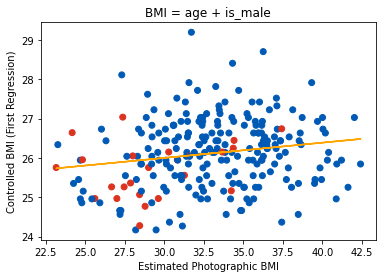

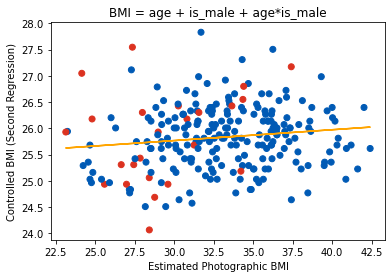

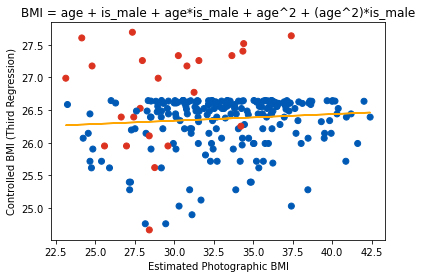

In [359]:
# graph estimated BMI against regressed BMI
# simple_scatter(ministers_results.estimated_bmi, ministers_results.first_reg, 'Estimated Photographic BMI', 'Controlled BMI (First Regression)', 'Estimated BMI and First Regression Results', regression_line=False)
# simple_scatter(ministers_results.estimated_bmi, ministers_results.second_reg, 'Estimated Photographic BMI', 'Controlled BMI (Second Regression)', 'Estimated BMI and Second Regression Results', regression_line=False)

fig1, ax1 = plt.subplots()
colors={'Male': '#005AB5', 'Female': '#DC3220'}

ax1.scatter(ministers_results.estimated_bmi, ministers_results.first_reg, c=ministers_results.sex.map(colors))
ax1.set_xlabel('Estimated Photographic BMI')
ax1.set_ylabel('Controlled BMI (First Regression)')
ax1.set_title('BMI = age + is_male')
m1, b1 = np.polyfit(ministers_results.estimated_bmi,
                  ministers_results.first_reg, 1)
ax1.plot(ministers_results.estimated_bmi, m1 *
         ministers_results.estimated_bmi+b1, color='orange')

fig1, ax2 = plt.subplots()

ax2.scatter(ministers_results.estimated_bmi,
            ministers_results.second_reg, c=ministers_results.sex.map(colors))
m2, b2 = np.polyfit(ministers_results.estimated_bmi,
                  ministers_results.second_reg, 1)
ax2.plot(ministers_results.estimated_bmi, m2 *
         ministers_results.estimated_bmi+b2, color='orange')
ax2.set_xlabel('Estimated Photographic BMI')
ax2.set_ylabel('Controlled BMI (Second Regression)')
ax2.set_title('BMI = age + is_male + age*is_male')

fig1, ax3 = plt.subplots()

ax3.scatter(ministers_results.estimated_bmi,
            ministers_results.third_reg, c=ministers_results.sex.map(colors))
m2, b2 = np.polyfit(ministers_results.estimated_bmi,
                  ministers_results.third_reg, 1)
ax3.plot(ministers_results.estimated_bmi, m2 *
         ministers_results.estimated_bmi+b2, color='orange')
ax3.set_xlabel('Estimated Photographic BMI')
ax3.set_ylabel('Controlled BMI (Third Regression)')
ax3.set_title('BMI = age + is_male + age*is_male + age^2 + (age^2)*is_male')


## First Regression

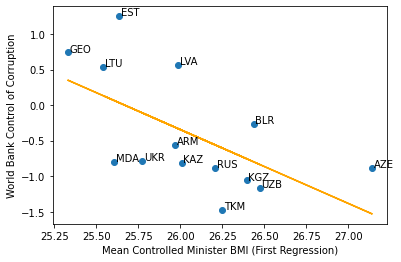

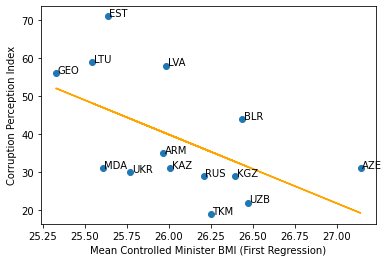

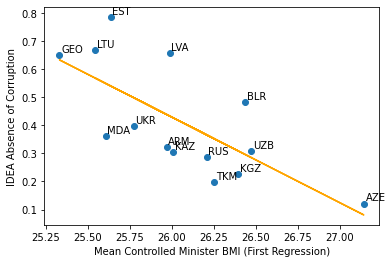

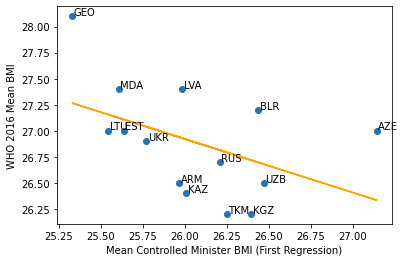

In [360]:
# check results of normalization against corruption measures
first_means = ministers_results.groupby('country').first_reg.mean()
corruption_minus_tajikstan = corruption.drop('Tajikistan')

def first_reg_scatter(measure, ylabel):
    annotate_scatter(
        first_means, 
        corruption_minus_tajikstan[measure], 
        abbrviate_countries(corruption_minus_tajikstan.index), 
        x_adjust=0.01, y_adjust=0.01, 
        xlabel="Mean Controlled Minister BMI (First Regression)", 
        ylabel=ylabel
        )


first_reg_scatter('control_of_corruption', "World Bank Control of Corruption")
first_reg_scatter('corruption perception index',
                  "Corruption Perception Index")
first_reg_scatter('IDEA absence of corruption',
                  "IDEA Absence of Corruption")

bmi_means_2016 = bmi['2016Both sexes'].drop('Tajikistan')

annotate_scatter(
    first_means,
    bmi_means_2016,
    abbrviate_countries(first_means.index),
    0.01, 0.01,
    'Mean Controlled Minister BMI (First Regression)',
    'WHO 2016 Mean BMI'
)


In [361]:
regress(corruption_minus_tajikstan['control_of_corruption'], first_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.352
Model:                               OLS   Adj. R-squared:                  0.298
Method:                    Least Squares   F-statistic:                     6.508
Date:                   Thu, 14 Jul 2022   Prob (F-statistic):             0.0254
Time:                           21:45:48   Log-Likelihood:                -13.749
No. Observations:                     14   AIC:                             31.50
Df Residuals:                         12   BIC:                             32.78
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.6892     10.621      2.513      0.027       3.549      49.829
first_reg     -1.0398      0.408     -2.551      0.025      -1.928      -0.152
==============================================================================
Omnibus:                        1.608   Durbin-Watson:                   1.152
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                0.992
Skew:                           0.323   Prob(JB):                        0.609
Kurtosis:                       1.868   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [362]:
regress(
    corruption_minus_tajikstan['corruption perception index'], first_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.293
Model:                                     OLS   Adj. R-squared:                  0.234
Method:                          Least Squares   F-statistic:                     4.982
Date:                         Thu, 14 Jul 2022   Prob (F-statistic):             0.0454
Time:                                 21:45:48   Log-Likelihood:                -55.624
No. Observations:                           14   AIC:                             115.2
Df Residuals:                               12   BIC:                             116.5
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        510.7349    211.412      2.416      0.033      50.107     971.363
first_reg    -18.1087      8.113     -2.232      0.045     -35.786      -0.432
==============================================================================
Omnibus:                        1.875   Durbin-Watson:                   1.076
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.130
Skew:                           0.395   Prob(JB):                        0.568
Kurtosis:                       1.854   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [363]:
regress(corruption_minus_tajikstan['IDEA absence of corruption'], first_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.504
Model:                                    OLS   Adj. R-squared:                  0.463
Method:                         Least Squares   F-statistic:                     12.21
Date:                        Thu, 14 Jul 2022   Prob (F-statistic):            0.00442
Time:                                21:45:48   Log-Likelihood:                 7.8097
No. Observations:                          14   AIC:                            -11.62
Df Residuals:                              12   BIC:                            -10.34
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3695      2.277      3.676      0.003       3.408      13.331
first_reg     -0.3054      0.087     -3.495      0.004      -0.496      -0.115
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.245
Skew:                           0.493   Prob(JB):                        0.537
Kurtosis:                       1.921   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [364]:
regress(bmi_means_2016, first_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         2016Both sexes   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     3.259
Date:                Thu, 14 Jul 2022   Prob (F-statistic):             0.0962
Time:                        21:45:48   Log-Likelihood:                -8.7718
No. Observations:                  14   AIC:                             21.54
Df Residuals:                      12   BIC:                             22.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.3264      7.443      5.418      0.000      24.110      56.543
first_reg     -0.5156      0.286     -1.805      0.096      -1.138       0.107
==============================================================================
Omnibus:                        1.824   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.402   Jarque-Bera (JB):                1.151
Skew:                           0.425   Prob(JB):                        0.562
Kurtosis:                       1.882   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Second Regression

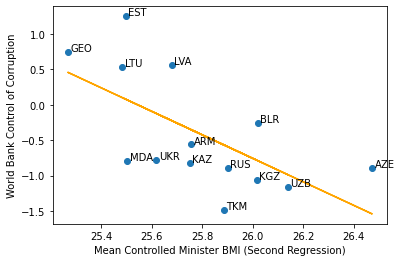

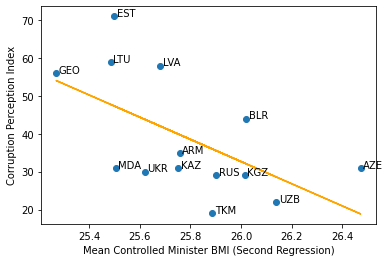

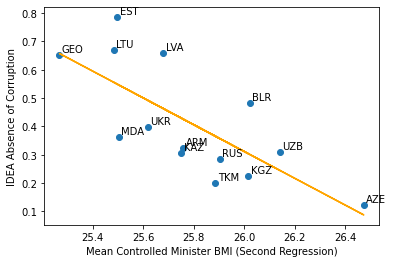

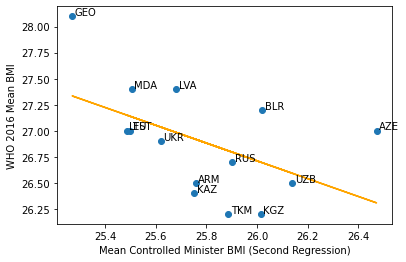

In [365]:
second_means = ministers_results.groupby('country').second_reg.mean()
corruption_minus_tajikstan = corruption.drop('Tajikistan')


def second_reg_scatter(measure, ylabel):
    annotate_scatter(
        second_means,
        corruption_minus_tajikstan[measure],
        abbrviate_countries(corruption_minus_tajikstan.index),
        x_adjust=0.01, y_adjust=0.01,
        xlabel="Mean Controlled Minister BMI (Second Regression)",
        ylabel=ylabel
    )


second_reg_scatter('control_of_corruption', "World Bank Control of Corruption")
second_reg_scatter('corruption perception index',
                  "Corruption Perception Index")
second_reg_scatter('IDEA absence of corruption',
                  "IDEA Absence of Corruption")

bmi_means_2016 = bmi['2016Both sexes'].drop('Tajikistan')

annotate_scatter(
    second_means,
    bmi_means_2016,
    abbrviate_countries(first_means.index),
    0.01, 0.01,
    'Mean Controlled Minister BMI (Second Regression)',
    'WHO 2016 Mean BMI'
)


In [366]:
regress(
    corruption_minus_tajikstan['control_of_corruption'], second_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.395
Model:                               OLS   Adj. R-squared:                  0.345
Method:                    Least Squares   F-statistic:                     7.846
Date:                   Thu, 14 Jul 2022   Prob (F-statistic):             0.0160
Time:                           21:45:49   Log-Likelihood:                -13.261
No. Observations:                     14   AIC:                             30.52
Df Residuals:                         12   BIC:                             31.80
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.4394     15.296      2.775      0.017       9.113      75.766
second_reg    -1.6614      0.593     -2.801      0.016      -2.954      -0.369
==============================================================================
Omnibus:                        1.115   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.573   Jarque-Bera (JB):                0.789
Skew:                           0.225   Prob(JB):                        0.674
Kurtosis:                       1.928   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [367]:
regress(
    corruption_minus_tajikstan['corruption perception index'], second_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.336
Model:                                     OLS   Adj. R-squared:                  0.281
Method:                          Least Squares   F-statistic:                     6.081
Date:                         Thu, 14 Jul 2022   Prob (F-statistic):             0.0297
Time:                                 21:45:49   Log-Likelihood:                -55.185
No. Observations:                           14   AIC:                             114.4
Df Residuals:                               12   BIC:                             115.6
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        792.3402    305.554      2.593      0.024     126.596    1458.084
second_reg   -29.2181     11.849     -2.466      0.030     -55.035      -3.402
==============================================================================
Omnibus:                        1.566   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                0.991
Skew:                           0.335   Prob(JB):                        0.609
Kurtosis:                       1.882   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [368]:
regress(
    corruption_minus_tajikstan['IDEA absence of corruption'], second_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.534
Model:                                    OLS   Adj. R-squared:                  0.495
Method:                         Least Squares   F-statistic:                     13.74
Date:                        Thu, 14 Jul 2022   Prob (F-statistic):            0.00300
Time:                                21:45:49   Log-Likelihood:                 8.2363
No. Observations:                          14   AIC:                            -12.47
Df Residuals:                              12   BIC:                            -11.19
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6196      3.294      3.831      0.002       5.443      19.796
second_reg    -0.4734      0.128     -3.706      0.003      -0.752      -0.195
==============================================================================
Omnibus:                        2.102   Durbin-Watson:                   1.348
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.173
Skew:                           0.386   Prob(JB):                        0.556
Kurtosis:                       1.810   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [369]:
regress(bmi_means_2016, second_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         2016Both sexes   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     4.166
Date:                Thu, 14 Jul 2022   Prob (F-statistic):             0.0639
Time:                        21:45:49   Log-Likelihood:                -8.3673
No. Observations:                  14   AIC:                             20.73
Df Residuals:                      12   BIC:                             22.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.9021     10.783      4.535      0.001      25.407      72.397
second_reg    -0.8535      0.418     -2.041      0.064      -1.765       0.058
==============================================================================
Omnibus:                        1.705   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.055
Skew:                           0.364   Prob(JB):                        0.590
Kurtosis:                       1.870   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## First Difference Regression

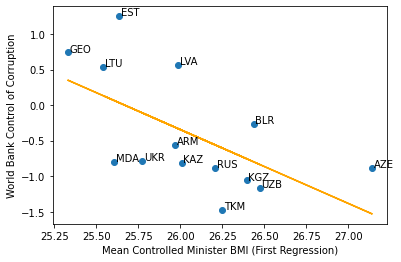

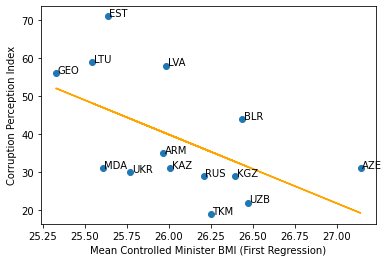

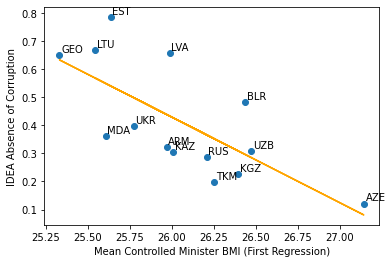

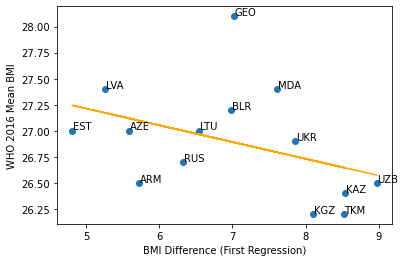

In [370]:
# check results of photographic BMI minus normalized BMI against corruption and country BMI
first_diff_means = ministers_results.groupby('country').first_diff.mean()
corruption_minus_tajikstan = corruption.drop('Tajikistan')

def first_diff_reg_scatter(measure, ylabel):
    annotate_scatter(
        first_diff_means, 
        corruption_minus_tajikstan[measure], 
        abbrviate_countries(corruption_minus_tajikstan.index), 
        x_adjust=0.01, y_adjust=0.01, 
        xlabel="BMI Difference (First Regression)", 
        ylabel=ylabel
        )


first_reg_scatter('control_of_corruption', "World Bank Control of Corruption")
first_reg_scatter('corruption perception index',
                  "Corruption Perception Index")
first_reg_scatter('IDEA absence of corruption',
                  "IDEA Absence of Corruption")

bmi_means_2016 = bmi['2016Both sexes'].drop('Tajikistan')

annotate_scatter(
    first_diff_means,
    bmi_means_2016,
    abbrviate_countries(first_diff_means.index),
    0.01, 0.01,
    'BMI Difference (First Regression)',
    'WHO 2016 Mean BMI'
)

In [371]:
regress(
    corruption_minus_tajikstan['control_of_corruption'], first_diff_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.440
Model:                               OLS   Adj. R-squared:                  0.393
Method:                    Least Squares   F-statistic:                     9.420
Date:                   Thu, 14 Jul 2022   Prob (F-statistic):            0.00973
Time:                           21:45:50   Log-Likelihood:                -12.727
No. Observations:                     14   AIC:                             29.45
Df Residuals:                         12   BIC:                             30.73
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4959      0.960      2.601      0.023       0.405       4.587
first_diff    -0.4145      0.135     -3.069      0.010      -0.709      -0.120
==============================================================================
Omnibus:                        0.051   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.249
Skew:                           0.101   Prob(JB):                        0.883
Kurtosis:                       2.378   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [372]:
regress(
    corruption_minus_tajikstan['corruption perception index'], first_diff_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.472
Model:                                     OLS   Adj. R-squared:                  0.429
Method:                          Least Squares   F-statistic:                     10.75
Date:                         Thu, 14 Jul 2022   Prob (F-statistic):            0.00660
Time:                                 21:45:50   Log-Likelihood:                -53.577
No. Observations:                           14   AIC:                             111.2
Df Residuals:                               12   BIC:                             112.4
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.1782     17.755      5.417      0.000      57.494     134.863
first_diff    -8.1929      2.499     -3.278      0.007     -13.638      -2.748
==============================================================================
Omnibus:                        0.379   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.827   Jarque-Bera (JB):                0.487
Skew:                          -0.081   Prob(JB):                        0.784
Kurtosis:                       2.101   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [373]:
regress(
    corruption_minus_tajikstan['IDEA absence of corruption'], first_diff_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.230
Model:                                    OLS   Adj. R-squared:                  0.166
Method:                         Least Squares   F-statistic:                     3.580
Date:                        Thu, 14 Jul 2022   Prob (F-statistic):             0.0828
Time:                                21:45:50   Log-Likelihood:                 4.7232
No. Observations:                          14   AIC:                            -5.446
Df Residuals:                              12   BIC:                            -4.168
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9264      0.276      3.358      0.006       0.325       1.528
first_diff    -0.0735      0.039     -1.892      0.083      -0.158       0.011
==============================================================================
Omnibus:                        1.283   Durbin-Watson:                   1.244
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                0.680
Skew:                          -0.529   Prob(JB):                        0.712
Kurtosis:                       2.786   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [374]:
regress(bmi_means_2016, first_diff_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         2016Both sexes   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2.347
Date:                Thu, 14 Jul 2022   Prob (F-statistic):              0.151
Time:                        21:45:50   Log-Likelihood:                -9.2030
No. Observations:                  14   AIC:                             22.41
Df Residuals:                      12   BIC:                             23.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.0170      0.746     37.553      0.000      26.391      29.643
first_diff    -0.1609      0.105     -1.532      0.151      -0.390       0.068
==============================================================================
Omnibus:                        6.269   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                3.179
Skew:                           1.089   Prob(JB):                        0.204
Kurtosis:                       3.840   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Second Difference Regression

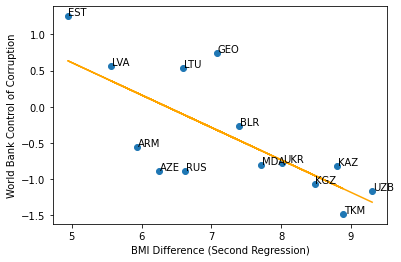

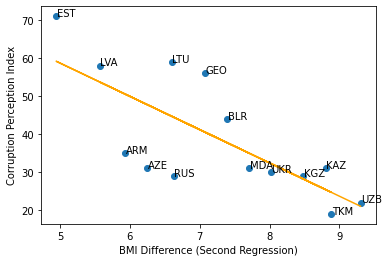

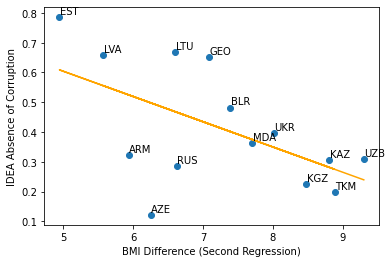

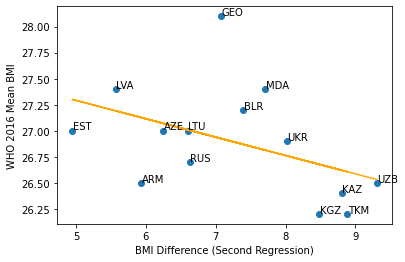

In [375]:
# check results of photographic BMI minus normalized BMI against corruption and country BMI
second_diff_means = ministers_results.groupby('country').second_diff.mean()
corruption_minus_tajikstan = corruption.drop('Tajikistan')

def second_diff_reg_scatter(measure, ylabel):
    annotate_scatter(
        second_diff_means, 
        corruption_minus_tajikstan[measure], 
        abbrviate_countries(corruption_minus_tajikstan.index), 
        x_adjust=0.01, y_adjust=0.01, 
        xlabel="BMI Difference (Second Regression)", 
        ylabel=ylabel
        )


second_diff_reg_scatter('control_of_corruption', "World Bank Control of Corruption")
second_diff_reg_scatter('corruption perception index',
                  "Corruption Perception Index")
second_diff_reg_scatter('IDEA absence of corruption',
                  "IDEA Absence of Corruption")

bmi_means_2016 = bmi['2016Both sexes'].drop('Tajikistan')

annotate_scatter(
    second_diff_means,
    bmi_means_2016,
    abbrviate_countries(first_diff_means.index),
    0.01, 0.01,
    'BMI Difference (Second Regression)',
    'WHO 2016 Mean BMI'
)

In [376]:
regress(
    corruption_minus_tajikstan['control_of_corruption'], second_diff_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.520
Model:                               OLS   Adj. R-squared:                  0.480
Method:                    Least Squares   F-statistic:                     13.02
Date:                   Thu, 14 Jul 2022   Prob (F-statistic):            0.00359
Time:                           21:45:51   Log-Likelihood:                -11.640
No. Observations:                     14   AIC:                             27.28
Df Residuals:                         12   BIC:                             28.56
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.8511      0.915      3.115      0.009       0.857       4.846
second_diff    -0.4482      0.124     -3.608      0.004      -0.719      -0.178
==============================================================================
Omnibus:                        0.057   Durbin-Watson:                   0.955
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.288
Skew:                          -0.012   Prob(JB):                        0.866
Kurtosis:                       2.298   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [377]:
regress(
    corruption_minus_tajikstan['corruption perception index'], second_diff_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.546
Model:                                     OLS   Adj. R-squared:                  0.508
Method:                          Least Squares   F-statistic:                     14.41
Date:                         Thu, 14 Jul 2022   Prob (F-statistic):            0.00255
Time:                                 21:45:51   Log-Likelihood:                -52.531
No. Observations:                           14   AIC:                             109.1
Df Residuals:                               12   BIC:                             110.3
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         102.4255     16.988      6.029      0.000      65.413     139.438
second_diff    -8.7509      2.305     -3.797      0.003     -13.773      -3.729
==============================================================================
Omnibus:                        0.838   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.658   Jarque-Bera (JB):                0.703
Skew:                          -0.229   Prob(JB):                        0.704
Kurtosis:                       2.002   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [378]:
regress(
    corruption_minus_tajikstan['IDEA absence of corruption'], second_diff_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.309
Model:                                    OLS   Adj. R-squared:                  0.252
Method:                         Least Squares   F-statistic:                     5.378
Date:                        Thu, 14 Jul 2022   Prob (F-statistic):             0.0388
Time:                                21:45:51   Log-Likelihood:                 5.4876
No. Observations:                          14   AIC:                            -6.975
Df Residuals:                              12   BIC:                            -5.697
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0279      0.269      3.816      0.002       0.441       1.615
second_diff    -0.0848      0.037     -2.319      0.039      -0.164      -0.005
==============================================================================
Omnibus:                        1.960   Durbin-Watson:                   1.197
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.090
Skew:                          -0.677   Prob(JB):                        0.580
Kurtosis:                       2.817   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [379]:
regress(bmi_means_2016, second_diff_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         2016Both sexes   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     2.986
Date:                Thu, 14 Jul 2022   Prob (F-statistic):              0.110
Time:                        21:45:51   Log-Likelihood:                -8.8982
No. Observations:                  14   AIC:                             21.80
Df Residuals:                      12   BIC:                             23.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          28.1732      0.753     37.433      0.000      26.533      29.813
second_diff    -0.1765      0.102     -1.728      0.110      -0.399       0.046
==============================================================================
Omnibus:                        5.792   Durbin-Watson:                   2.420
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                2.871
Skew:                           1.041   Prob(JB):                        0.238
Kurtosis:                       3.766   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""